In [3]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import gamma, kv
import seaborn as sns
import os

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

# Create img directory if it doesn't exist
img_dir = '../report/img'
os.makedirs(img_dir, exist_ok=True)
print(f"Images will be saved to: {img_dir}")

Images will be saved to: ../report/img


## 1. Multivariate Normal Distributions

Visualizing different covariance matrices and their effects on 2D Gaussian distributions.

Saved: multivariate_normal_distributions.png


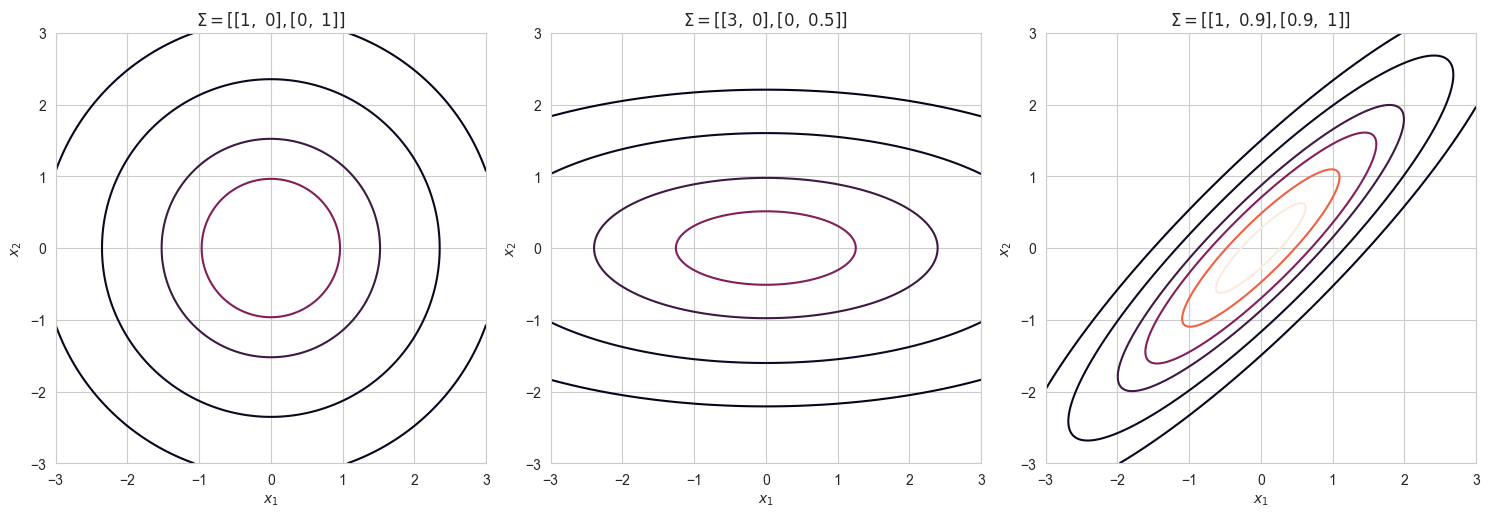

In [4]:
# Create three different Gaussian distributions with different covariance matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define domain
x = np.linspace(-3, 3, 201)
y = np.linspace(-3, 3, 201)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Mean vector
mean = [0, 0]

# Three different covariance matrices
covariances = [
    np.array([[1, 0], [0, 1]]),
    np.array([[3, 0], [0, 0.5]]),
    np.array([[1, 0.9], [0.9, 1]])
]

titles = [
    r'$\Sigma = [[1,\ 0],[0,\ 1]]$',
    r'$\Sigma = [[3,\ 0],[0,\ 0.5]]$',
    r'$\Sigma = [[1,\ 0.9],[0.9,\ 1]]$'
]

for idx, (cov, title) in enumerate(zip(covariances, titles)):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    
    cs = axes[idx].contour(X, Y, Z, levels=[0.001, 0.01, 0.05, 0.1, 0.2, 0.3])
    axes[idx].set_xlabel('$x_1$')
    axes[idx].set_ylabel('$x_2$')
    axes[idx].set_title(title)
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_aspect('equal')

plt.tight_layout()
plt.savefig(f'{img_dir}/multivariate_normal_distributions.png', dpi=300, bbox_inches='tight')
print("Saved: multivariate_normal_distributions.png")
plt.show()

## 2. Gaussian Process Class

Implementation of a basic Gaussian Process with customizable kernel functions.

In [5]:
class GaussianProcess:
    def __init__(self, mean_func=None, kernel_func=None, noise_var=0.0):
        """
        Initialize Gaussian Process
        
        Parameters:
        - mean_func: Mean function (default: zero mean)
        - kernel_func: Kernel/covariance function
        - noise_var: Observation noise variance
        """
        self.mean_func = mean_func if mean_func else lambda x: 0.0
        self.kernel_func = kernel_func if kernel_func else self._default_kernel
        self.noise_var = noise_var
        
        # Training data
        self.X_train = []
        self.y_train = []
    
    def _default_kernel(self, x1, x2):
        """Default squared exponential kernel"""
        return np.exp(-0.5 * np.linalg.norm(x1 - x2)**2)
    
    def add_data(self, x, y):
        """Add training data point"""
        self.X_train.append(np.array(x))
        self.y_train.append(y)
    
    def kernel_matrix(self, X1, X2):
        """Compute kernel matrix between two sets of points"""
        K = np.zeros((len(X1), len(X2)))
        for i, x1 in enumerate(X1):
            for j, x2 in enumerate(X2):
                K[i, j] = self.kernel_func(x1, x2)
        return K
    
    def sample(self, X, n_samples=1):
        """Sample from the GP prior at points X"""
        n = len(X)
        K = self.kernel_matrix(X, X)
        
        # Add small jitter for numerical stability
        K += 1e-8 * np.eye(n)
        
        # Compute mean
        mean = np.array([self.mean_func(x) for x in X])
        
        # Sample from multivariate normal
        samples = np.random.multivariate_normal(mean, K, n_samples)
        
        return samples.T if n_samples > 1 else samples[0]
    
    def predict(self, X_test):
        """Predict mean and variance at test points"""
        if len(self.X_train) == 0:
            # Prior prediction
            mean = np.array([self.mean_func(x) for x in X_test])
            var = np.array([self.kernel_func(x, x) for x in X_test])
            return mean, var
        
        # Compute kernel matrices
        K = self.kernel_matrix(self.X_train, self.X_train)
        K_s = self.kernel_matrix(self.X_train, X_test)
        K_ss = self.kernel_matrix(X_test, X_test)
        
        # Add noise to diagonal
        K += self.noise_var * np.eye(len(self.X_train))
        
        # Compute posterior mean and covariance
        K_inv = np.linalg.inv(K)
        y_train = np.array(self.y_train)
        mean_train = np.array([self.mean_func(x) for x in self.X_train])
        
        mu = np.array([self.mean_func(x) for x in X_test]) + K_s.T @ K_inv @ (y_train - mean_train)
        cov = K_ss - K_s.T @ K_inv @ K_s
        var = np.diag(cov)
        
        return mu, var

print("GaussianProcess class defined successfully!")

GaussianProcess class defined successfully!


## 3. GP Samples with Different Length Scales

Demonstrating how the length scale parameter affects GP samples.

Saved: gp_samples_length_scales.png


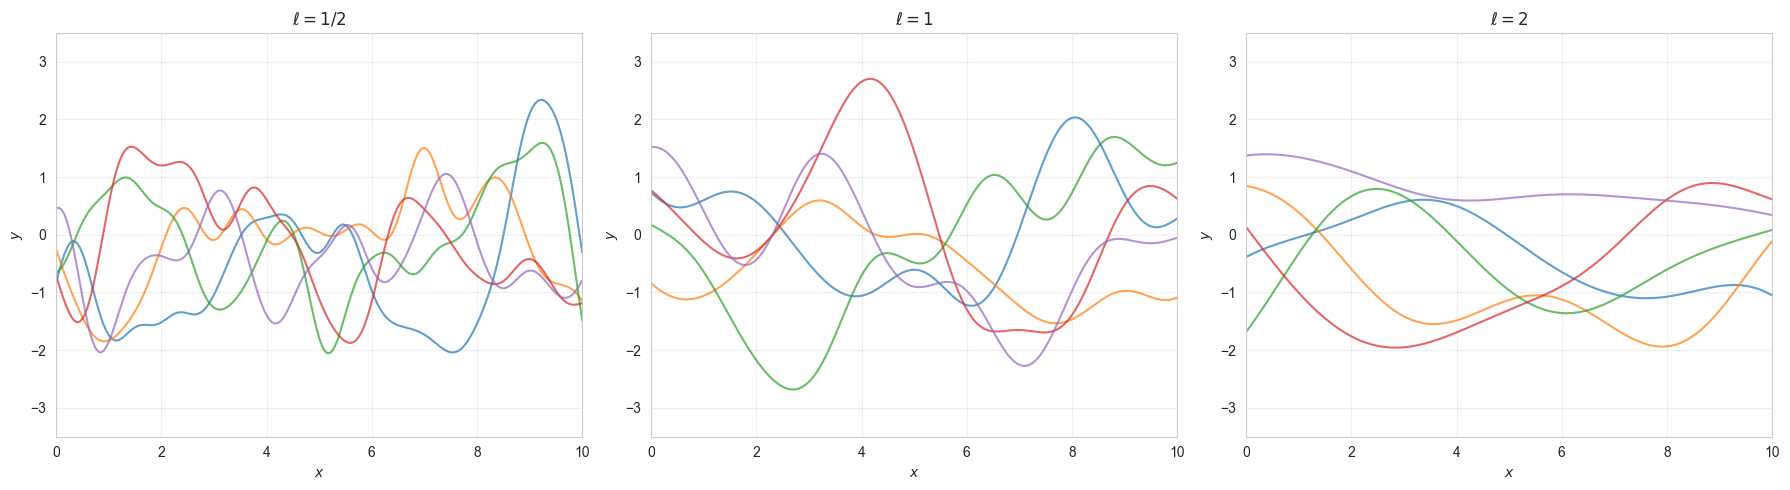

In [6]:
# Sample from GP with different length scales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

np.random.seed(0)
X = np.linspace(0, 10, 201).reshape(-1, 1)

length_scales = [0.5, 1.0, 2.0]
titles = [r'$\ell = 1/2$', r'$\ell = 1$', r'$\ell = 2$']

for idx, (l, title) in enumerate(zip(length_scales, titles)):
    # Define kernel with specific length scale
    kernel = lambda x1, x2, l=l: np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * l**2))
    
    gp = GaussianProcess(kernel_func=kernel)
    
    # Generate 5 samples
    for i in range(5):
        y = gp.sample(X)
        axes[idx].plot(X.flatten(), y, alpha=0.7)
    
    axes[idx].set_xlabel('$x$')
    axes[idx].set_ylabel('$y$')
    axes[idx].set_title(title)
    axes[idx].set_xlim(0, 10)
    axes[idx].set_ylim(-3.5, 3.5)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{img_dir}/gp_samples_length_scales.png', dpi=300, bbox_inches='tight')
print("Saved: gp_samples_length_scales.png")
plt.show()

## 4. Different Kernel Functions

Implementation and visualization of various common kernel functions.

<>:42: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:43: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:44: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:45: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:46: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:47: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:42: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences wil

Saved: different_kernel_functions.png


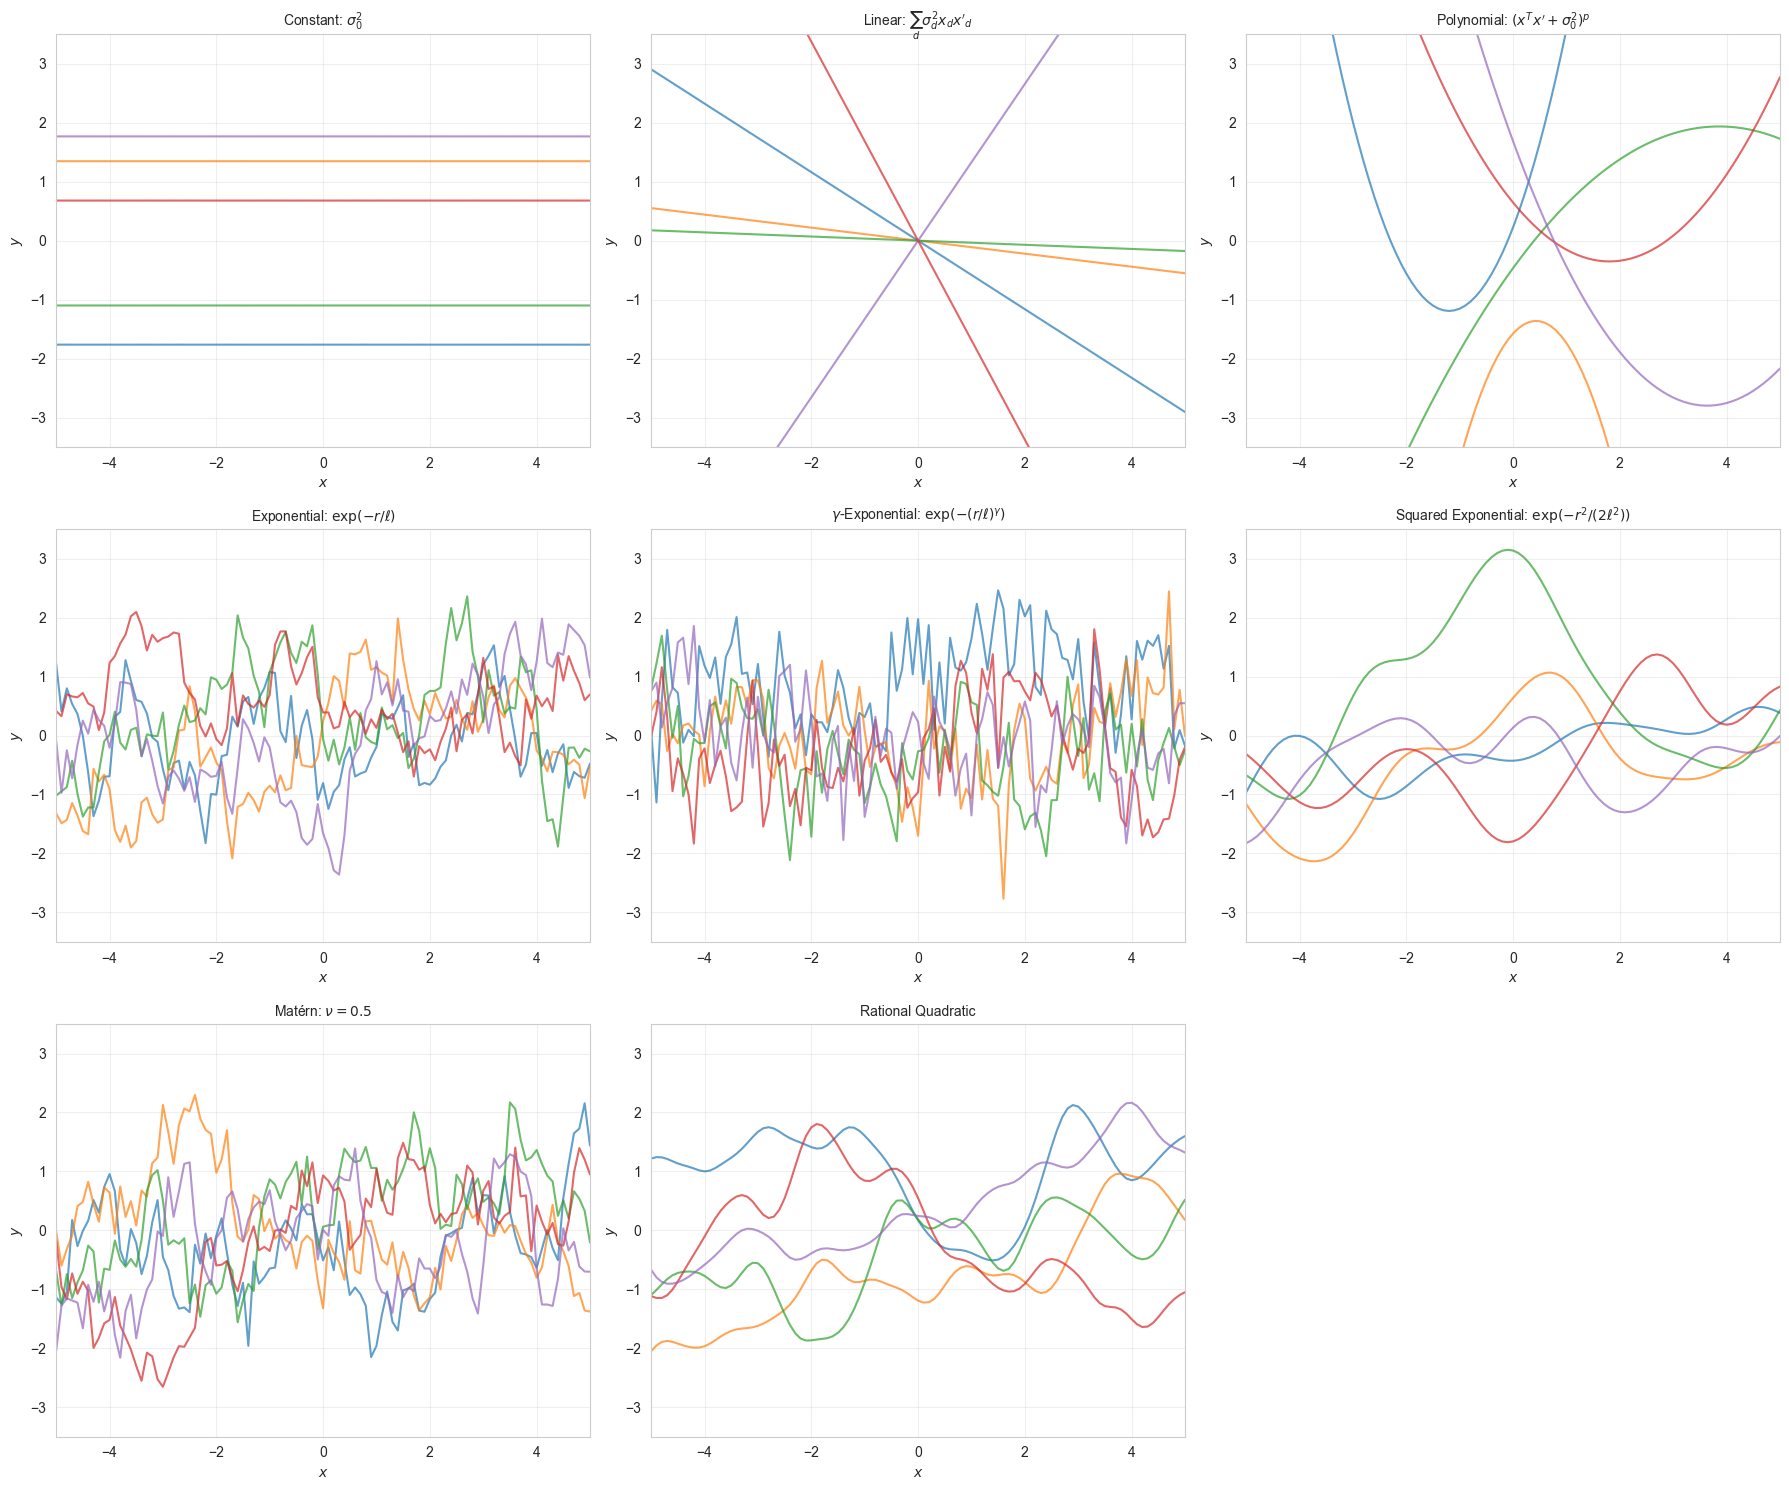

In [7]:
# Define various kernel functions
def constant_kernel(x1, x2):
    """Constant kernel"""
    return 1.0

def linear_kernel(x1, x2):
    """Linear kernel"""
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, degree=2, sigma0=1.0):
    """Polynomial kernel"""
    return (np.dot(x1, x2) + sigma0**2)**degree

def exponential_kernel(x1, x2, length_scale=1.0):
    """Exponential kernel"""
    return np.exp(-np.abs(x1[0] - x2[0]) / length_scale)

def gamma_exponential_kernel(x1, x2, length_scale=1.0, gamma=0.5):
    """Gamma-exponential kernel"""
    return np.exp(-(np.linalg.norm(x1 - x2) / length_scale)**gamma)

def squared_exponential_kernel(x1, x2, length_scale=1.0):
    """Squared exponential (RBF) kernel"""
    return np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * length_scale**2))

def matern_kernel(x1, x2, nu=0.5, length_scale=1.0):
    """Matérn kernel"""
    r = np.linalg.norm(x1 - x2)
    if np.isclose(r, 0.0):
        return 1.0
    
    g = np.sqrt(2 * nu) * r / length_scale
    return (2**(1 - nu)) / gamma(nu) * g**nu * kv(nu, g)

def rational_quadratic_kernel(x1, x2, alpha=0.5, length_scale=1.0):
    """Rational quadratic kernel"""
    r = np.linalg.norm(x1 - x2)
    return (1 + r**2 / (2 * alpha * length_scale**2))**(-alpha)

# Visualize samples from different kernels
kernels = [
    (constant_kernel, "Constant: $\sigma_0^2$"),
    (linear_kernel, "Linear: $\sum_d \sigma_d^2 x_d x'_d$"),
    (lambda x1, x2: polynomial_kernel(x1, x2, 2, 1.0), "Polynomial: $(x^T x' + \sigma_0^2)^p$"),
    (exponential_kernel, "Exponential: $\exp(-r/\ell)$"),
    (gamma_exponential_kernel, "$\gamma$-Exponential: $\exp(-(r/\ell)^\gamma)$"),
    (squared_exponential_kernel, "Squared Exponential: $\exp(-r^2/(2\ell^2))$"),
    (lambda x1, x2: matern_kernel(x1, x2, 0.5, 1.0), "Matérn: $\\nu=0.5$"),
    (rational_quadratic_kernel, "Rational Quadratic"),
]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

np.random.seed(0)
X = np.linspace(-5, 5, 101).reshape(-1, 1)

for idx, (kernel, title) in enumerate(kernels):
    if idx >= len(axes):
        break
    
    gp = GaussianProcess(kernel_func=kernel)
    
    # Generate 5 samples
    for i in range(5):
        y = gp.sample(X)
        axes[idx].plot(X.flatten(), y, alpha=0.7)
    
    axes[idx].set_xlabel('$x$')
    axes[idx].set_ylabel('$y$')
    axes[idx].set_title(title, fontsize=10)
    axes[idx].set_xlim(-5, 5)
    axes[idx].set_ylim(-3.5, 3.5)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplot
if len(kernels) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig(f'{img_dir}/different_kernel_functions.png', dpi=300, bbox_inches='tight')
print("Saved: different_kernel_functions.png")
plt.show()

## 5. 2D Gaussian Process Samples

Visualizing GP samples in 2D with different length scales.

Saved: gp_2d_samples.png


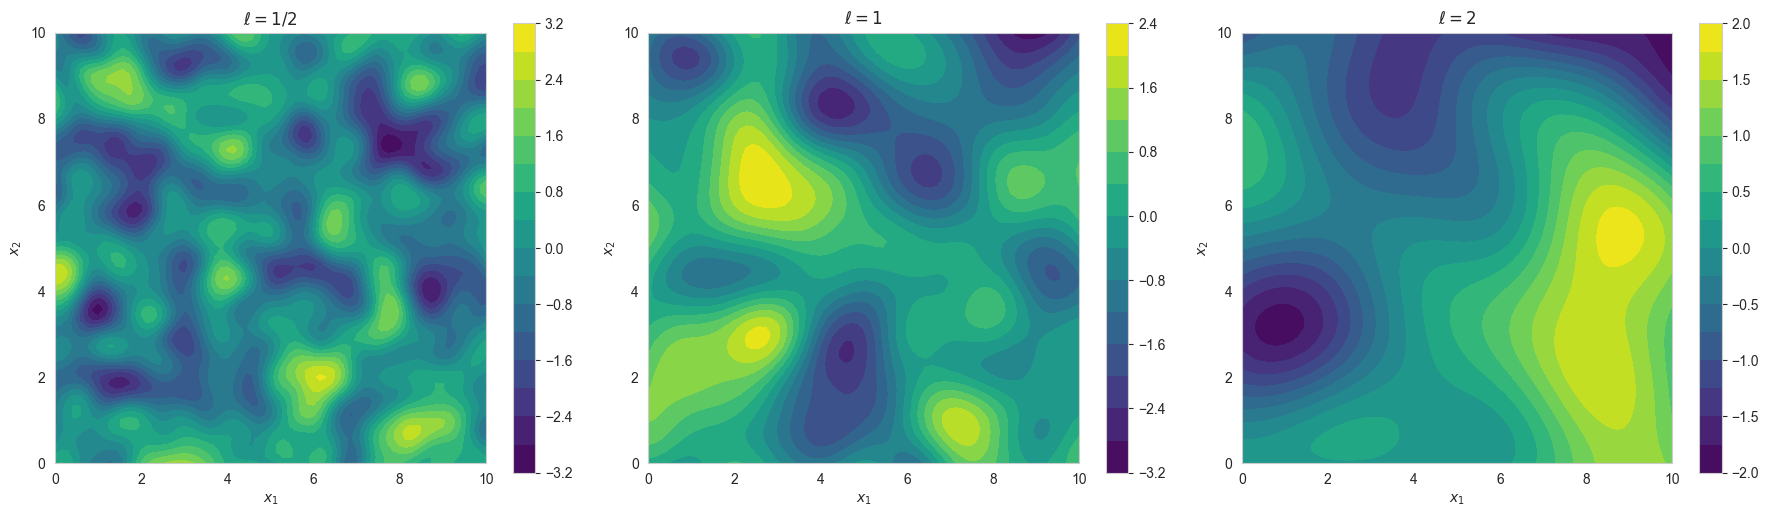

In [8]:
# 2D GP samples with different length scales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x_arr = np.linspace(0, 10, 71)
y_arr = np.linspace(0, 10, 71)
X_mesh, Y_mesh = np.meshgrid(x_arr, y_arr)
X_2d = np.column_stack([X_mesh.ravel(), Y_mesh.ravel()])

length_scales = [0.5, 1.0, 2.0]
titles = [r'$\ell = 1/2$', r'$\ell = 1$', r'$\ell = 2$']

np.random.seed(0)

for idx, (l, title) in enumerate(zip(length_scales, titles)):
    kernel = lambda x1, x2, l=l: np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * l**2))
    gp = GaussianProcess(kernel_func=kernel)
    
    # Sample from GP
    z = gp.sample(X_2d)
    Z = z.reshape(X_mesh.shape)
    
    # Plot contours
    cs = axes[idx].contourf(X_mesh, Y_mesh, Z, levels=15, cmap='viridis')
    axes[idx].set_xlabel('$x_1$')
    axes[idx].set_ylabel('$x_2$')
    axes[idx].set_title(title)
    axes[idx].set_aspect('equal')
    plt.colorbar(cs, ax=axes[idx])

plt.tight_layout()
plt.savefig(f'{img_dir}/gp_2d_samples.png', dpi=300, bbox_inches='tight')
print("Saved: gp_2d_samples.png")
plt.show()

## 6. GP Regression (Fitting)

Demonstrating Gaussian Process regression with training data.

Saved: gp_regression_fitting.png


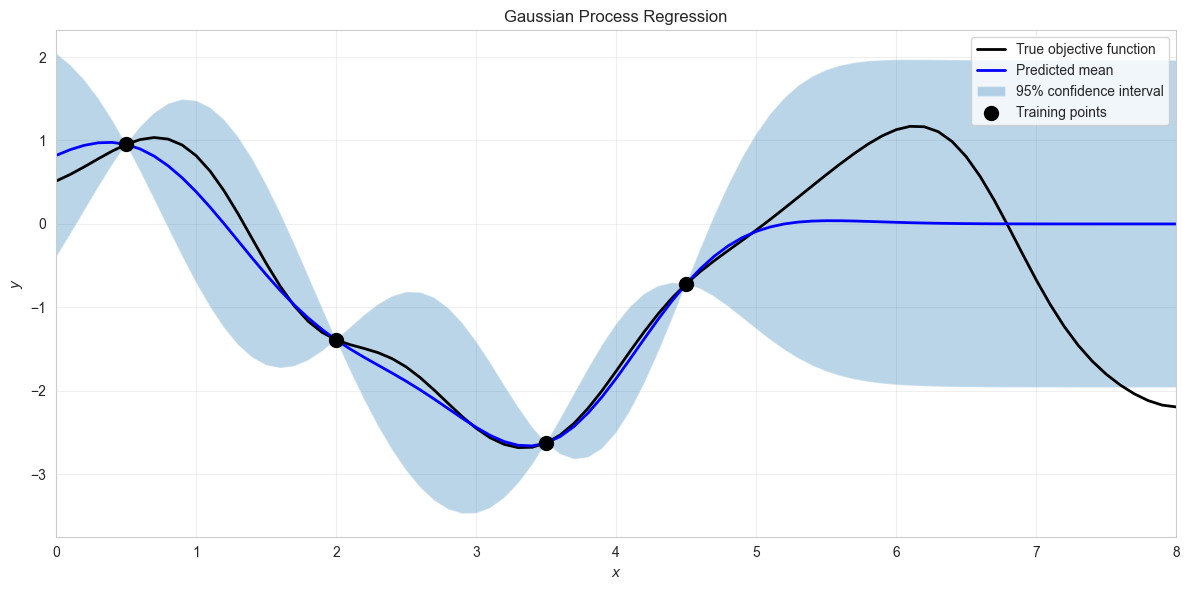

In [9]:
# GP Regression example
np.random.seed(0)

# Create true function
X_full = np.linspace(0, 10, 101).reshape(-1, 1)
kernel = lambda x1, x2: np.exp(-np.linalg.norm(x1 - x2)**2)
gp_true = GaussianProcess(kernel_func=kernel)
y_true = gp_true.sample(X_full)

# Create training data
train_indices = [5, 20, 35, 45]
X_train = X_full[train_indices]
y_train = y_true[train_indices]

# Create GP and add training data
gp = GaussianProcess(kernel_func=kernel)
for x, y in zip(X_train, y_train):
    gp.add_data(x, y)

# Make predictions
mu, var = gp.predict(X_full)
std = np.sqrt(var)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_full, y_true, 'k-', label='True objective function', linewidth=2)
plt.plot(X_full, mu, 'b-', label='Predicted mean', linewidth=2)
plt.fill_between(X_full.flatten(), 
                  mu - 1.96*std, 
                  mu + 1.96*std, 
                  alpha=0.3, 
                  label='95% confidence interval')
plt.scatter(X_train, y_train, c='black', s=100, zorder=5, label='Training points')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(0, 8)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.title('Gaussian Process Regression')
plt.tight_layout()
plt.savefig(f'{img_dir}/gp_regression_fitting.png', dpi=300, bbox_inches='tight')
print("Saved: gp_regression_fitting.png")
plt.show()

## 7. GP with Gradient Information

Implementing GP that uses both function values and gradients.

In [10]:
class GaussianProcessWithGradient:
    def __init__(self, alpha=1.0, gamma=1.5):
        """
        GP with gradient information
        
        Parameters:
        - alpha: Amplitude parameter
        - gamma: Length scale parameter
        """
        self.alpha = alpha
        self.gamma = gamma
        
        self.X_train = []
        self.y_train = []
        self.grad_train = []
    
    def kff(self, x1, x2):
        """Kernel between function values"""
        diff = x1 - x2
        return self.alpha * np.exp(-0.5 * self.gamma * np.dot(diff, diff))
    
    def k_grad_f(self, x1, x2, j):
        """Kernel between gradient and function"""
        diff = x1 - x2
        return -self.gamma * self.alpha * (x2[j] - x1[j]) * np.exp(-0.5 * self.gamma * np.dot(diff, diff))
    
    def k_grad_grad(self, x1, x2, i, j):
        """Kernel between gradients"""
        diff = x1 - x2
        delta_ij = 1 if i == j else 0
        return self.gamma * self.alpha * (delta_ij - self.gamma * (x1[j] - x2[j]) * (x1[i] - x2[i])) * \
               np.exp(-0.5 * self.gamma * np.dot(diff, diff))
    
    def add_data(self, x, y, grad_y):
        """Add training data with gradient"""
        self.X_train.append(np.array(x))
        self.y_train.append(y)
        self.grad_train.append(np.array(grad_y))
    
    def predict(self, X_test):
        """Predict with gradient information"""
        n_train = len(self.X_train)
        n_test = len(X_test)
        d = len(self.X_train[0])
        
        # Build kernel matrices
        Kff = np.zeros((n_train, n_train))
        for i in range(n_train):
            for j in range(n_train):
                Kff[i, j] = self.kff(self.X_train[i], self.X_train[j])
        
        K_grad_f = np.zeros((n_train, n_train * d))
        for i in range(n_train):
            for j in range(n_train):
                for a in range(d):
                    K_grad_f[i, d*j + a] = self.k_grad_f(self.X_train[i], self.X_train[j], a)
        
        K_grad_grad = np.zeros((n_train * d, n_train * d))
        for i in range(n_train):
            for j in range(n_train):
                for a in range(d):
                    for b in range(d):
                        K_grad_grad[d*i + a, d*j + b] = self.k_grad_grad(self.X_train[i], self.X_train[j], a, b)
        
        # Build training kernel matrix
        V = np.block([
            [Kff, K_grad_f],
            [K_grad_f.T, K_grad_grad]
        ])
        
        # Build test kernel matrix
        Kpf = np.zeros((n_test, n_train))
        for i in range(n_test):
            for j in range(n_train):
                Kpf[i, j] = self.kff(X_test[i], self.X_train[j])
        
        K_grad_p = np.zeros((n_train * d, n_test))
        for i in range(n_train):
            for j in range(n_test):
                for a in range(d):
                    K_grad_p[d*i + a, j] = self.k_grad_f(self.X_train[i], X_test[j], a)
        
        v = np.vstack([Kpf.T, K_grad_p])
        
        # Prepare training data
        y = np.array(self.y_train)
        grads = np.concatenate([-np.array(g) for g in self.grad_train])
        y_combined = np.concatenate([y, grads])
        
        # Predict
        V_inv = np.linalg.inv(V + 1e-8 * np.eye(V.shape[0]))
        mu = v.T @ V_inv @ y_combined
        
        # Variance
        Kpp = np.array([self.kff(x, x) for x in X_test])
        var = Kpp - np.diag(v.T @ V_inv @ v) + 1e-8
        
        return mu, var

print("GaussianProcessWithGradient class defined successfully!")

GaussianProcessWithGradient class defined successfully!


/tmp/ipykernel_407214/1050837518.py:28: RuntimeWarning: invalid value encountered in sqrt
  std_with_grad = np.sqrt(var_with_grad)


Saved: gp_with_gradient.png


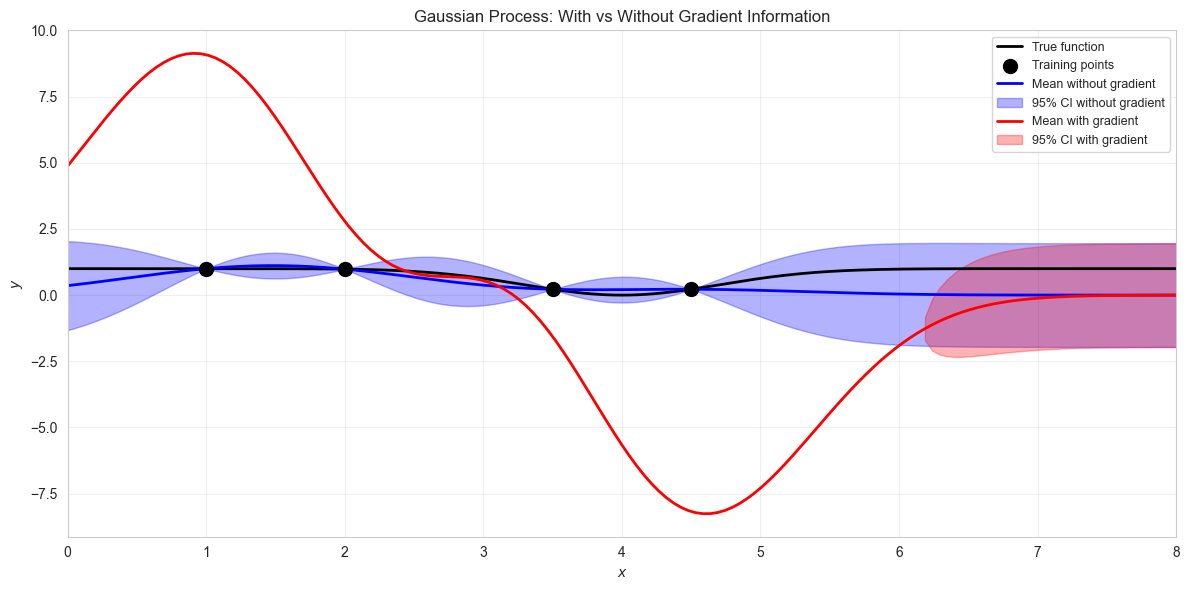

In [11]:
# Compare GP with and without gradient information
np.random.seed(0)

# Define true function
f = lambda x: 1 - np.exp(-(x[0] - 4)**2)
grad_f = lambda x: np.array([2 * np.exp(-(x[0] - 4)**2) * (x[0] - 4)])

# Training points
X_train_points = [np.array([1.0]), np.array([2.0]), np.array([3.5]), np.array([4.5])]
X_test = np.linspace(0, 8, 151).reshape(-1, 1)

# GP without gradient
gp_no_grad = GaussianProcess(
    kernel_func=lambda x1, x2: 1.0 * np.exp(-0.5 * 1.5 * np.dot(x1-x2, x1-x2))
)
for x in X_train_points:
    gp_no_grad.add_data(x, f(x))

mu_no_grad, var_no_grad = gp_no_grad.predict(X_test)
std_no_grad = np.sqrt(var_no_grad)

# GP with gradient
gp_with_grad = GaussianProcessWithGradient(alpha=1.0, gamma=1.5)
for x in X_train_points:
    gp_with_grad.add_data(x, f(x), grad_f(x))

mu_with_grad, var_with_grad = gp_with_grad.predict(X_test)
std_with_grad = np.sqrt(var_with_grad)

# Plot
plt.figure(figsize=(12, 6))

# True function
y_true = np.array([f(x) for x in X_test])
plt.plot(X_test, y_true, 'k-', label='True function', linewidth=2)

# Training points
y_train = np.array([f(x) for x in X_train_points])
plt.scatter([x[0] for x in X_train_points], y_train, c='black', s=100, zorder=5, label='Training points')

# Without gradient
plt.plot(X_test, mu_no_grad, 'b-', label='Mean without gradient', linewidth=2)
plt.fill_between(X_test.flatten(), 
                  mu_no_grad - 1.96*std_no_grad, 
                  mu_no_grad + 1.96*std_no_grad, 
                  alpha=0.3, color='blue',
                  label='95% CI without gradient')

# With gradient
plt.plot(X_test, mu_with_grad, 'r-', label='Mean with gradient', linewidth=2)
plt.fill_between(X_test.flatten(), 
                  mu_with_grad - 1.96*std_with_grad, 
                  mu_with_grad + 1.96*std_with_grad, 
                  alpha=0.3, color='red',
                  label='95% CI with gradient')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(0, 8)
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.title('Gaussian Process: With vs Without Gradient Information')
plt.tight_layout()
plt.savefig(f'{img_dir}/gp_with_gradient.png', dpi=300, bbox_inches='tight')
print("Saved: gp_with_gradient.png")
plt.show()

## 8. GP with Noisy Observations

Demonstrating GP regression with observation noise.

Saved: gp_noisy_observations.png


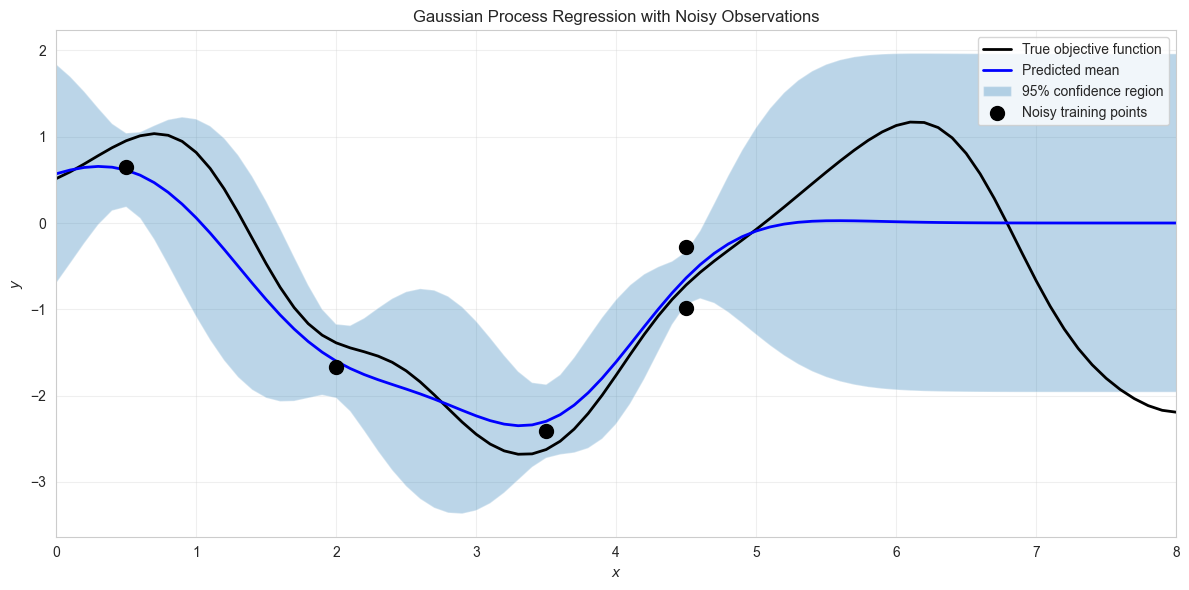

In [12]:
# GP with noisy observations
np.random.seed(0)

# Create true function
kernel = lambda x1, x2: np.exp(-np.linalg.norm(x1 - x2)**2)
gp_true = GaussianProcess(kernel_func=kernel)
X_full = np.linspace(0, 10, 101).reshape(-1, 1)
y_true = gp_true.sample(X_full)

# Create noisy training data
train_indices = [5, 20, 35, 45, 45]  # Note: 45 appears twice
noise_std = np.sqrt(0.05)
X_train = X_full[train_indices]
y_train_noisy = y_true[train_indices] + np.random.randn(len(train_indices)) * noise_std

# Create GP with noise
gp_noisy = GaussianProcess(kernel_func=kernel, noise_var=0.05)
for x, y in zip(X_train, y_train_noisy):
    gp_noisy.add_data(x, y)

# Make predictions
mu, var = gp_noisy.predict(X_full)
std = np.sqrt(var)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_full, y_true, 'k-', label='True objective function', linewidth=2)
plt.plot(X_full, mu, 'b-', label='Predicted mean', linewidth=2)
plt.fill_between(X_full.flatten(), 
                  mu - 1.96*std, 
                  mu + 1.96*std, 
                  alpha=0.3, 
                  label='95% confidence region')
plt.scatter(X_train, y_train_noisy, c='black', s=100, zorder=5, label='Noisy training points')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(0, 8)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.title('Gaussian Process Regression with Noisy Observations')
plt.tight_layout()
plt.savefig(f'{img_dir}/gp_noisy_observations.png', dpi=300, bbox_inches='tight')
print("Saved: gp_noisy_observations.png")
plt.show()